# 실제 신용카드 사기 데이터셋을 활용해 클래스 불균형 상황에서 분류 모델을 학습
### 2021147586 안재후

# 1. 데이터 로드 및 기본 탐색


In [1]:
import pandas as pd

# 데이터 로드
df = pd.read_csv('creditcard.csv')

# 구조 확인
print(df.head())
print(df.info())
print(df.describe())

# 클래스 비율 확인
print("\nClass Distribution (Counts):")
print(df['Class'].value_counts())
print("\nClass Distribution (Ratio):")
print(df['Class'].value_counts(normalize=True))

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

# 2. 샘플링

In [3]:
df_fraud = df[df['Class'] == 1]
df_normal = df[df['Class'] == 0]

# 정상 거래 10,000건 무작위 샘플링
df_normal_sampled = df_normal.sample(n=10000, random_state=42)

df_new = pd.concat([df_fraud, df_normal_sampled], axis=0)

# 새로운 분포 확인
print("New Class Distribution (Counts):")
print(df_new['Class'].value_counts())
print("\nNew Class Distribution (Ratio):")
print(df_new['Class'].value_counts(normalize=True))

New Class Distribution (Counts):
Class
0    10000
1      492
Name: count, dtype: int64

New Class Distribution (Ratio):
Class
0    0.953107
1    0.046893
Name: proportion, dtype: float64


# 3. 데이터 전처리

In [4]:
from sklearn.preprocessing import StandardScaler

# Amount 변수 표준화 및 원본 Amount 제거
scaler = StandardScaler()
df_new['Amount_Scaled'] = scaler.fit_transform(df_new[['Amount']])

df_new = df_new.drop('Amount', axis=1)

# Time 변수 제거 
# (Time 변수는 사기 거래 탐지 학습에 도움이 덜 될 것 같아서 배제)
df_new = df_new.drop('Time', axis=1)

# X, y 분리
X = df_new.drop('Class', axis=1)
y = df_new['Class']

print("X shape:", X.shape)
print("y shape:", y.shape)
print("X columns:", X.columns)

X shape: (10492, 29)
y shape: (10492,)
X columns: Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount_Scaled'],
      dtype='object')


# 4. 학습 데이터와 테스트 데이터 분할

In [5]:
from sklearn.model_selection import train_test_split

# 데이터 분할 (train : test = 8 : 2, 클래스 비율 유지)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train set Class Distribution (Ratio):")
print(y_train.value_counts(normalize=True))
print("\nTest set Class Distribution (Ratio):")
print(y_test.value_counts(normalize=True))

Train set Class Distribution (Ratio):
Class
0    0.953056
1    0.046944
Name: proportion, dtype: float64

Test set Class Distribution (Ratio):
Class
0    0.953311
1    0.046689
Name: proportion, dtype: float64


# 5. SMOTE 적용

In [7]:
from imblearn.over_sampling import SMOTE

# SMOTE 적용 전 클래스 분포 확인
print("Before SMOTE - y_train distribution:")
print(y_train.value_counts())

# SMOTE 적용 (random_state=42)
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# SMOTE 적용 후 클래스 분포 확인
print("\nAfter SMOTE - y_train_sm distribution:")
print(y_train_sm.value_counts())

Before SMOTE - y_train distribution:
Class
0    7999
1     394
Name: count, dtype: int64

After SMOTE - y_train_sm distribution:
Class
0    7999
1    7999
Name: count, dtype: int64


### SMOTE 적용 이유:

Random sampling이 진행된 이후에도, 현재 데이터는 정상 거래(데이터 전체의 95.31%)가 사기 거래(데이터 전체의 4.69%)보다 훨씬 많은 불균형 상태입니다. 클래스 불균형 상태에서 학습한다면 모델이 ‘정상’ 클래스만 예측하려는 편향이 생겨 분류 문제를 해결하기 어렵습니다. Random sampling과 다르게 SMOTE는 단순히 데이터를 복제하지 않고 소수 클래스 데이터를 분석해 유사한 데이터를 생성하므로 Overfitting 위험을 줄이면서 클래스 균형을 맞출 수 있습니다.

# 6. 모델 학습


### 모델: Logistic Regression
**선정 이유**: Binary classification 문제에서 빠르고 안정적이게 사용 가능

### 학습 데이터: 'X_train_sm', 'y_train_sm' (SMOTE 적용된 데이터)
**선정 이유**: 클래스 불균형이 해소된 데이터를 사용하여 사기 거래(Class=1)에 대한 학습 비중을 높임

### 평가 데이터: 'X_test', 'y_test' (원본에서 샘플링된 테스트 데이터)
**선정 이유**: SMOTE된 데이터로 테스트하면 실제 환경과 다르게 성능이 과대평가될 수 있으므로, 평가는 (클래스 불균형이라도) 실제 데이터를 사용함

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, average_precision_score

# 모델 학습 (SMOTE 데이터 사용)
model = LogisticRegression(random_state=42)
model.fit(X_train_sm, y_train_sm)

# 예측 (원본 테스트 데이터 사용)
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 성능 평가
print(classification_report(y_test, y_pred))

# PR-AUC 계산
pr_auc = average_precision_score(y_test, y_pred_proba)
print(f"PR-AUC Score: {pr_auc:.4f}")

              precision    recall  f1-score   support

           0       1.00      0.97      0.98      2001
           1       0.62      0.97      0.76        98

    accuracy                           0.97      2099
   macro avg       0.81      0.97      0.87      2099
weighted avg       0.98      0.97      0.97      2099

PR-AUC Score: 0.9559


# 7. 최종 성능 평가 (Hyperparameter Tuning & Threshold Adjustment)


In [16]:
import numpy as np

# Threshold 높게 조정 (0.9)
updated_threshold = 0.9
updated_y_pred = (y_pred_proba >= updated_threshold).astype(int)

# Classification Report 계산
print(classification_report(y_test, updated_y_pred))

# PR-AUC Score 계산
pr_auc_updated = average_precision_score(y_test, y_pred_proba)
print(f"\nPR-AUC Score (Updated Threshold): {pr_auc_updated:.4f}")

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2001
           1       0.89      0.90      0.89        98

    accuracy                           0.99      2099
   macro avg       0.94      0.95      0.94      2099
weighted avg       0.99      0.99      0.99      2099


PR-AUC Score (Updated Threshold): 0.9559


In [20]:
# precision-recall curve 계산
precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)

# F1 Score가 최대가 되는 임계값 탐색
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Maximum F1-Score: {f1_scores[optimal_idx]:.4f}")

# 최적 임계값 적용하여 예측
y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

# 최종 성능 평가
print(classification_report(y_test, y_pred_optimal))

# PR-AUC Score 계산
pr_auc_updated = average_precision_score(y_test, y_pred_proba)
print(f"\nPR-AUC Score (Updated Threshold): {pr_auc_updated:.4f}")

Optimal Threshold: 0.9581
Maximum F1-Score: 0.9091
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2001
           1       0.96      0.87      0.91        98

    accuracy                           0.99      2099
   macro avg       0.97      0.93      0.95      2099
weighted avg       0.99      0.99      0.99      2099


PR-AUC Score (Updated Threshold): 0.9559


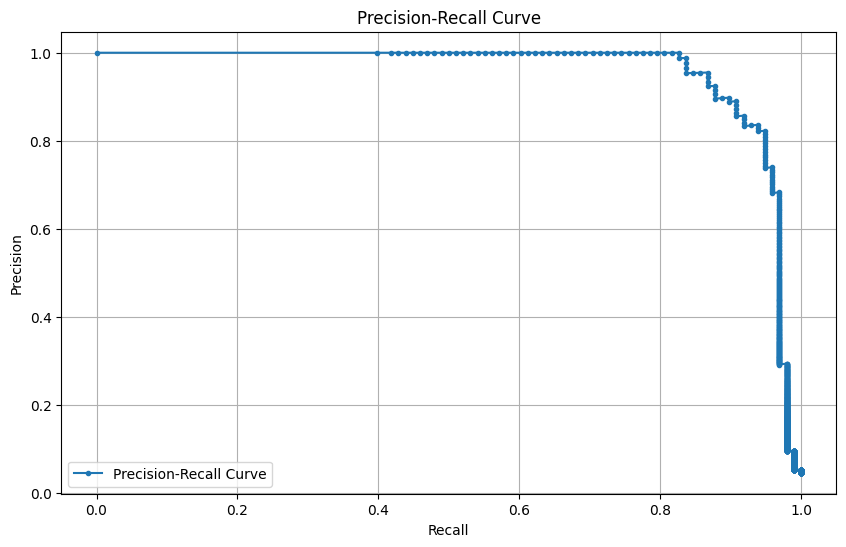

In [21]:
# Precision-Recall Curve 시각화

import matplotlib.pyplot as plt

# 시각화
plt.figure(figsize=(10, 6))
plt.plot(recalls, precisions, marker='.', label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


## 달성 여부 및 제안
- **Recall**: 0.80 이상 달성 (성공)
- **PR-AUC**: 0.90 이상 달성 (성공)
- **F1-score**: 0.88 이상 달성 (성공)

**만약 달성하지 못했다면**, Logistic Regression 모델의 한계일 수도 있어서 Random Forest 모델 등 타 모델을 통해 성능을 올릴 수 있습니다.